# Gaussian Mixture Modelling on Spend Behaviour

In this notebook, we will:

- Load 2 preprocessed datasets (no missing values).
- Perform basic exploratory analysis.
- Do feature engineering and categorical encoding.
- Apply multiple clustering algorithms on spend-related features:
  - K-Means
  - Hierarchical clustering
  - DBSCAN
- Systematically loop over hyperparameters, generate plots, and store results.

The main variable of interest is `spend_category`, and we’ll engineer and encode features suitable for unsupervised clustering.


In [5]:
# standard libraries
import os
import numpy as np
import pandas as pd
from pathlib import Path

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing & clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import json

# for later steps (clustering & metrics)
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# display & style
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

## Data Loading

We define a helper function that:
- Reads a CSV given a path.
- Prints basic info for sanity checks.


In [6]:
def load_dataset(path: str, name: str = "dataset"):
    assert os.path.exists(path), f"File not found: {path}"
    df = pd.read_csv(path)
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)
    print("Columns:", list(df.columns))
    print("\nData types:")
    print(df.dtypes)
    # print("\nSample rows:")
    # display(df.head())
    return df

dataset_dir = Path.cwd().parent / "datasets" / "preprocessed"
train = load_dataset(dataset_dir.joinpath("train_preprocessed.csv"), "train")
test = load_dataset(dataset_dir.joinpath("test_preprocessed.csv"), "test")


=== train ===
Shape: (10492, 22)
Columns: ['trip_id', 'country', 'age_group', 'travel_companions', 'num_females', 'num_males', 'main_activity', 'visit_purpose', 'is_first_visit', 'mainland_stay_nights', 'island_stay_nights', 'tour_type', 'intl_transport_included', 'info_source', 'accomodation_included', 'food_included', 'domestic_transport_included', 'sightseeing_included', 'guide_included', 'insurance_included', 'total_trip_days', 'spend_category']

Data types:
trip_id                         object
country                         object
age_group                       object
travel_companions               object
num_females                    float64
num_males                      float64
main_activity                   object
visit_purpose                   object
is_first_visit                  object
mainland_stay_nights             int64
island_stay_nights               int64
tour_type                       object
intl_transport_included         object
info_source              

## Feature Engineering & Preprocessing

We perform the following transformations:
1. **Typo Correction:** Fix "Widlife" to "Wildlife" in `main_activity`.
2. **Ordinal Mapping:** Convert `age_group` and `total_trip_days` to integer ranks to preserve the order of magnitude.
3. **Feature Creation:** Create `total_people`, `total_nights`, and `island_ratio` to capture group dynamics and trip structure.
4. **Encoding & Scaling:** One-Hot Encode categorical nominal variables and Scale numerical variables for Euclidean distance calculation.

In [7]:
# 1. Define Mappings based on the new eda.txt
# We map ranges to integers so the model understands "rank" (e.g., 65+ > 18-24)
AGE_MAP = {
    '<18': 0, '18-24': 1, '25-44': 2, '45-64': 3, '65+': 4
}

# Strictly mapping the 4 values found in eda.txt
TRIP_DAYS_MAP = {
    '1-6': 0, '7-14': 1, '15-30': 2, '30+': 3
}

# 2. Custom Feature Engineering Class
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # --- Data Cleaning ---
        # Fix typo found in EDA: 'Widlife' -> 'Wildlife' 
        if 'main_activity' in X.columns:
            X['main_activity'] = X['main_activity'].replace('Widlife Tourism', 'Wildlife Tourism')

        # --- Interaction Features ---
        # Total group size
        X['total_people'] = X['num_females'] + X['num_males']
        
        # Total stay duration
        X['total_nights'] = X['mainland_stay_nights'] + X['island_stay_nights']
        
        # Ratio of island stay (handling division by zero)
        X['island_ratio'] = X.apply(
            lambda row: row['island_stay_nights'] / row['total_nights'] if row['total_nights'] > 0 else 0, 
            axis=1
        )
        
        # --- Ordinal Mapping ---
        # Map ordinal columns; fill missing with -1
        X['age_group_ord'] = X['age_group'].map(AGE_MAP).fillna(-1)
        X['total_trip_days_ord'] = X['total_trip_days'].map(TRIP_DAYS_MAP).fillna(-1)
        
        # --- Binary Conversion ---
        # Convert Yes/No columns to 1/0
        binary_cols = ['is_first_visit', 'intl_transport_included', 
                       'accomodation_included', 'food_included', 
                       'domestic_transport_included', 'sightseeing_included', 
                       'guide_included', 'insurance_included']
        
        for col in binary_cols:
            if col in X.columns:
                X[col] = X[col].map({'Yes': 1, 'No': 0}).fillna(0)

        # Drop original columns that were transformed or are ID/Target
        # Removed 'days_booked_before_trip' as it is not in the dataset
        drop_cols = ['trip_id', 'country', 'age_group', 'total_trip_days', 
                     'num_females', 'num_males', 'mainland_stay_nights', 
                     'island_stay_nights', 'spend_category']
        
        # Only drop columns that actually exist in this dataframe
        cols_to_drop = [c for c in drop_cols if c in X.columns]
        
        return X.drop(columns=cols_to_drop)

# 3. Apply Engineering & Pipeline
# Separate Target from Train 
y_train = train['spend_category']
X_train_raw = train.drop(columns=['spend_category'])
X_test_raw = test.copy()

# Initialize our engineer
engineer = FeatureEngineer()
X_train_eng = engineer.transform(X_train_raw)

# Identify columns for OneHotEncoding (Nominal) vs Scaling (Numeric)
categorical_cols = X_train_eng.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical (OHE): {categorical_cols}")
print(f"Numerical (Scale): {numerical_cols}")

# Create the full Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit on train, transform both
X_train_processed = preprocessor.fit_transform(X_train_eng)
X_test_processed = preprocessor.transform(engineer.transform(X_test_raw))

# Retrieve feature names for clarity
num_names = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols)
cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = list(num_names) + list(cat_names)

# Convert back to DataFrames
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Final Processed Shape:", X_train_df.shape)
X_train_df.head()

Categorical (OHE): ['travel_companions', 'main_activity', 'visit_purpose', 'tour_type', 'info_source']
Numerical (Scale): ['is_first_visit', 'intl_transport_included', 'accomodation_included', 'food_included', 'domestic_transport_included', 'sightseeing_included', 'guide_included', 'insurance_included', 'total_people', 'total_nights', 'island_ratio', 'age_group_ord', 'total_trip_days_ord']
Final Processed Shape: (10492, 45)


,is_first_visit,intl_transport_included,accomodation_included,food_included,domestic_transport_included,sightseeing_included,guide_included,insurance_included,total_people,total_nights,...,tour_type_Independent,tour_type_Package Tour,"info_source_Friends, relatives",info_source_Inflight magazines,info_source_Mexican Mission Abroad,"info_source_Newspaper, magazines, brochures",info_source_Others,"info_source_Radio, TV, Web",info_source_Trade fair,"info_source_Travel agent, tour operator"
0,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,0.475269,-0.306795,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.478907,-0.371776,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.539253,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.371776,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.649666,1.345868,0.992026,1.061556,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.306795,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.649666,-0.743015,-1.008038,-0.942014,-0.870149,-0.692849,-0.720901,-0.425909,-0.001819,-0.631699,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 1. Dimensionality Reduction & GMM Hyperparameter Tuning

Unlike K-Means, Gaussian Mixture Models (GMM) are probabilistic. They assume data is generated from a mixture of several Gaussian distributions with unknown parameters.

In this step, we perform:
1.  **Dimensionality Reduction (PCA):** GMMs require estimating covariance matrices. High dimensionality makes this unstable (the "curse of dimensionality"). We optimize PCA to keep enough components to explain **95% of the variance**, ensuring the model has rich signal without noise.
2.  **Grid Search with BIC/AIC:** We cannot use the "Elbow Method" here. Instead, we use information criteria:
    * **BIC (Bayesian Information Criterion):** Penalizes model complexity heavily. Lower is better.
    * **AIC (Akaike Information Criterion):** Similar, but penalizes less.
3.  **Covariance Types:** We test four geometric assumptions about the clusters:
    * `'full'`: Each cluster has its own shape/orientation (most flexible).
    * `'tied'`: All clusters share the same shape.
    * `'diag'`: Clusters are aligned with axes.
    * `'spherical'`: Clusters are round (like K-Means).

Optimal PCA components (95% variance): 20
Running GMM Grid Search (this may take a minute)...

Best Model Configuration (Lowest BIC):
Components: 10
Covariance Type: full


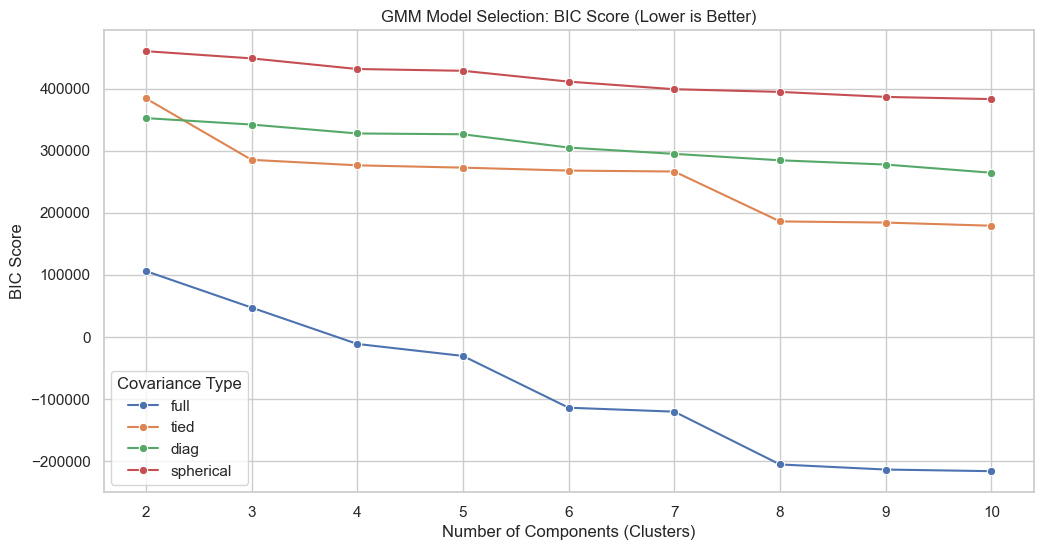

Average Cluster Certainty: 99.90%


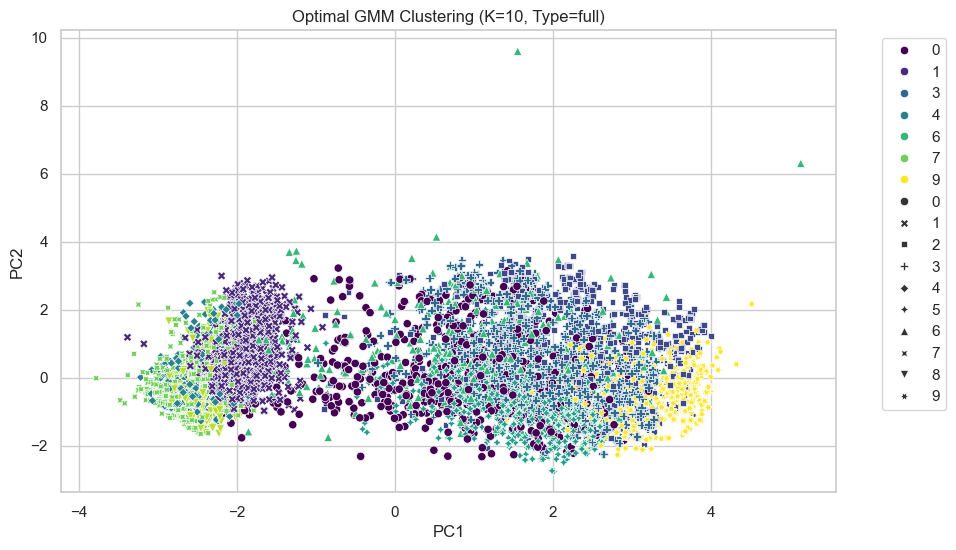

In [8]:
# --- 1. Optimize Dimensionality (PCA) ---
# Fit PCA to find how many components are needed for 95% variance
pca_full = PCA()
pca_full.fit(X_train_df)

# Calculate cumulative variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(f"Optimal PCA components (95% variance): {d}")

# Transform data using the optimal number of components
pca = PCA(n_components=d)
X_pca = pca.fit_transform(X_train_df)

# --- 2. GMM Hyperparameter Grid Search (BIC Score) ---
# We test different component counts and covariance structures
n_components_range = range(2, 11)
covariance_types = ['full', 'tied', 'diag', 'spherical']

results = []

print("Running GMM Grid Search (this may take a minute)...")

for n in n_components_range:
    for cov_type in covariance_types:
        gmm = GaussianMixture(n_components=n, covariance_type=cov_type, random_state=42)
        gmm.fit(X_pca)
        
        results.append({
            'Components': n,
            'Covariance Type': cov_type,
            'AIC': gmm.aic(X_pca),
            'BIC': gmm.bic(X_pca) # Lower BIC suggests a better model balance
        })

# Create DataFrame for analysis
results_df = pd.DataFrame(results)

# --- 3. Find Best Model (Minimize BIC) ---
best_model_row = results_df.loc[results_df['BIC'].idxmin()]
best_n = int(best_model_row['Components'])
best_cov = best_model_row['Covariance Type']

print(f"\nBest Model Configuration (Lowest BIC):")
print(f"Components: {best_n}")
print(f"Covariance Type: {best_cov}")

# --- 4. Visualization of Grid Search ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Components', y='BIC', hue='Covariance Type', marker='o')
plt.title('GMM Model Selection: BIC Score (Lower is Better)')
plt.xlabel('Number of Components (Clusters)')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

# --- 5. Final Fit with Best Parameters ---
best_gmm = GaussianMixture(n_components=best_n, covariance_type=best_cov, random_state=42)
best_gmm.fit(X_pca)

# Assign Hard Labels (for later comparison)
gmm_labels = best_gmm.predict(X_pca)
X_train_df['gmm_cluster'] = gmm_labels

# Calculate Certainty (Probability)
# predict_proba returns matrix of shape (n_samples, n_components)
probs = best_gmm.predict_proba(X_pca)
certainty = np.max(probs, axis=1) # The probability of the chosen cluster

print(f"Average Cluster Certainty: {np.mean(certainty):.2%}")

# Visualize Clusters (Projected to 2D for plotting)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='viridis', style=gmm_labels)
plt.title(f'Optimal GMM Clustering (K={best_n}, Type={best_cov})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 2. Cluster Profiling & Interpretation

Now that we have assigned probabilistic clusters using GMM, we need to validate if they make business sense.

In this step, we:
1.  **Map Clusters to Ground Truth:** We cross-reference our unsupervised `gmm_cluster` labels with the actual `spend_category` (0, 1, 2).
    * *Goal:* If "Cluster 0" is composed 90% of "High Spenders", we can confidently label that cluster as our high-value segment.
2.  **Visualize with Heatmap:** A heatmap will show us the "purity" of our clusters. Dark squares indicate strong correlation between a cluster and a specific spending behavior.
3.  **Behavioral Profiling:** We calculate the average values of key features (e.g., `total_nights`, `total_people`, `island_ratio`) for each cluster to understand *why* they were grouped together.


=== Cluster vs Spend Category Mapping (Counts) ===


actual_spend,0.0,1.0,2.0
gmm_cluster,,,
0,380,206,23
1,493,1112,248
2,558,91,8
3,1540,209,14
4,119,288,99
5,835,265,25
6,336,67,13
7,147,1166,549
8,77,511,159


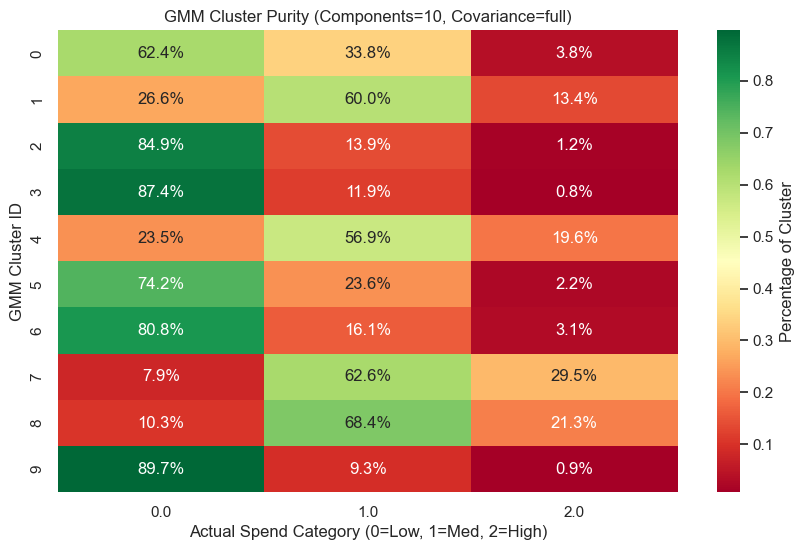


=== Cluster Behavioral Profile (Mean Values) ===


,total_nights,total_people,island_ratio,age_group_ord,actual_spend
gmm_cluster,,,,,
0,-0.028626,-0.254072,0.265545,0.046645,0.413793
1,0.106130,0.021868,0.052134,-0.335467,0.867782
2,-0.098995,0.132521,1.215656,-0.040384,0.162861
3,-0.107392,0.086400,0.422725,0.234414,0.134430
4,0.297553,0.309325,-0.276458,-0.002059,0.960474
5,-0.092040,-0.047195,-0.377743,0.235368,0.280000
6,-0.011726,1.755148,0.188565,-0.116190,0.223558
7,0.174245,-0.478907,-0.409514,-0.295063,1.215897
8,-0.265997,-0.321155,-0.353857,0.008082,1.109772


In [9]:
# --- 1. Map GMM Clusters to Actual Spend ---
# We verify if our unsupervised clusters align with the known spend categories
X_train_df['actual_spend'] = y_train.values

# Create Confusion Matrix (Crosstab)
cross_tab = pd.crosstab(X_train_df['gmm_cluster'], X_train_df['actual_spend'])
cross_tab_prop = pd.crosstab(X_train_df['gmm_cluster'], X_train_df['actual_spend'], normalize='index')

print("\n=== Cluster vs Spend Category Mapping (Counts) ===")
display(cross_tab)

# --- 2. Visualize Purity with Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab_prop, annot=True, fmt='.1%', cmap='RdYlGn', cbar_kws={'label': 'Percentage of Cluster'})
plt.title(f'GMM Cluster Purity (Components={best_n}, Covariance={best_cov})')
plt.ylabel('GMM Cluster ID')
plt.xlabel('Actual Spend Category (0=Low, 1=Med, 2=High)')
plt.show()

# --- 3. Behavioral Profile ---
# Calculate the mean of key features for each cluster to understand the "persona"
profiling_cols = ['total_nights', 'total_people', 'island_ratio', 'age_group_ord', 'actual_spend']
cluster_profile = X_train_df.groupby('gmm_cluster')[profiling_cols].mean()

print("\n=== Cluster Behavioral Profile (Mean Values) ===")
display(cluster_profile)

## 3. Submission Generation

Finally, we apply our trained Gaussian Mixture Model to the test dataset to generate predictions.

1.  **Transform Test Data:** We apply the same PCA transformation to the test data to ensure it matches the training data's structure.
2.  **Predict Clusters:** We assign each test trip to a GMM cluster.
3.  **Map to Spend Category:** We use the "Cluster -> Spend" mapping derived from our training data profiling (Step 2) to convert these cluster labels into the target `spend_category` (0, 1, 2).
4.  **Save:** The final results are saved to `submission_unsupervised_gmm.csv`.

In [10]:
# --- 1. Prepare Test Data ---
# Apply the same PCA transform used on Train
X_test_pca = pca.transform(X_test_df)

# --- 2. Predict Clusters on Test Data ---
test_gmm_labels = best_gmm.predict(X_test_pca)

# --- 3. Create Mapping: Cluster ID -> Most Frequent Spend Category ---
# We use the training data to learn what each cluster "means"
temp_df = pd.DataFrame({'cluster': gmm_labels, 'spend': y_train.values})

# Find the most common spend category for each cluster (Mode)
# If a cluster is empty (rare), we fill with the global mode
cluster_to_spend_map = temp_df.groupby('cluster')['spend'].agg(
    lambda x: pd.Series.mode(x)[0] if not x.mode().empty else y_train.mode()[0]
).to_dict()

print("\n=== GMM Mapping (Cluster -> Spend) ===")
print(cluster_to_spend_map)

# --- 4. Generate Submission ---
# Map the predicted clusters to spend categories
predicted_spend = pd.Series(test_gmm_labels).map(cluster_to_spend_map)

# Create DataFrame
submission = pd.DataFrame({
    'trip_id': test['trip_id'],
    'spend_category': predicted_spend
})

# Ensure data types are correct
submission['spend_category'] = submission['spend_category'].astype(int)

# Save to CSV
filename = "submission_unsupervised_gmm.csv"
submission.to_csv(filename, index=False)

print(f"\nSaved submission file: {filename}")
print(f"Shape: {submission.shape}")
submission.head()


=== GMM Mapping (Cluster -> Spend) ===
{0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0, 6: 0.0, 7: 1.0, 8: 1.0, 9: 0.0}

Saved submission file: submission_unsupervised_gmm.csv
Shape: (5852, 2)


,trip_id,spend_category
0,tour_id8gzpck76,1
1,tour_idow1zxkou,0
2,tour_idue7esfqz,0
3,tour_idnj3mjzpb,0
4,tour_ida3us5yk2,0
